In [1]:
import pandas as pd
import numpy as np
import orjson
import os

In [2]:
import Graphers as g

In [68]:
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
from dbscan1d.core import DBSCAN1D
import pyranges as pr

import argparse
import os
import logging
import warnings


def split_to_bed(df: pd.DataFrame, colname) -> pd.DataFrame:
    """ 
    Splits the given column into 3 columns with titles Chromosome, Start, End
    """
    split_data = df[colname].str.split(pat=':', n=1, expand=True)
    df['Chromosome'] = split_data[0]
    start_end_data = split_data[1].str.split(pat='-', n=1, expand=True)
    df['Start'] = start_end_data[0]
    df['End'] = start_end_data[1]
    return df


def get_COSMIC_regions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Get COSMIC regions from the dataframe.
    Args:
        df: Dataframe with locations of mutations.
    Returns:
        df: Dataframe with added COSMIC annotations
    """
    df_bed_format = split_to_bed(df, 'ReferenceRegion')

    # Convert pandas DataFrames to PyRanges objects
    pyranges_df = pr.PyRanges(df_bed_format)

    # Load the COSMIC data
    cosmic_data = pd.read_csv('../data/COSMIC.csv')
    pyranges_cosmic = pr.PyRanges(cosmic_data)

    # Join the data with COSMIC regions using a left join
    joined_pyranges = pyranges_df.join(pyranges_cosmic, how='left')
    joined_df = joined_pyranges.df

    # Create a 'COSMIC_loc' column combining 'Start' and 'End'
    joined_df['COSMIC_loc'] = joined_df['Start_b'].astype(str) + '-' + joined_df['End_b'].astype(str)

    # Drop unnecessary columns
    columns_to_drop = ['Start', 'End', 'Start_b', 'End_b', 'Chromosome']
    joined_df.drop(columns=columns_to_drop, inplace=True)

    # Rename columns for clarity
    columns_to_rename = {
        'Tumour Types(Somatic)': 'COSMIC_TumorType', 
        'Tissue Type': 'COSMIC_TissueType',
        'Gene Symbol': 'COSMIC_GeneSymbol', 
        'Tier': 'COSMIC_Tier'
    }
    joined_df.rename(columns=columns_to_rename, inplace=True)

    return joined_df


def calculate_wilcoxon_pvals(df: pd.DataFrame) -> np.ndarray:
    """
    Calculate Wilcoxon p-values for each column in a dataframe.
    Args:
        df: Dataframe with rows as samples and cols as regions.
    Returns:
        pvals: Array of p-values for each region.
    """
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("once")
        pvals = wilcoxon(df, nan_policy='omit', axis=0)[1]
        for warning in w:
            if str(warning.message) == 'Exact p-value calculation does not work if there are zeros. Switching to normal approximation.':
                logging.warning('Exact p-value calculation switched to normal approximation due to presence of zeros.')
            elif str(warning.message) == 'Sample size too small for normal approximation.':
                logging.warning('Sample size is too small for normal approximation.')
    _, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    return pvals_corrected



def process_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove columns with all zeros and sample_id column if present.
    Args:
        df: Dataframe with rows as samples and cols as regions.
    Returns:
        df: Processed dataframe.
    """
    if 'sample_id' in df.columns:
        df.drop(columns=['sample_id'], axis=1, inplace=True)
    df = df.loc[:, (df.fillna(0) != 0).any(axis=0)]
    return df


# Need to add motif extraction to GenotypeGetter & Remove this
def add_motif_info(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Add motif information to the dataframe, from the locus_structures.csv file.
    Args:
        df: Dataframe with rows as samples and cols as regions.
    Returns:
        df: Dataframe with motif information added.
    """
    loc_to_motif = pd.read_csv('../data/other/locus_structures.csv')
    loc_to_motif['ReferenceRegion'] = loc_to_motif['ReferenceRegion'].str.lstrip('chr')
    df = df.merge(loc_to_motif[['ReferenceRegion', 'LocusStructure']], on='ReferenceRegion', how='left')
    return df


def cluster_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Call cluster function to get cluster features for each locus. 
    Args:
        df: Dataframe with rows as samples and cols as regions.
    Returns:
        cluster_df: With Cols ['num_clusters', 'cluster_means', 'cluster_sds', 'out3', 'out5']
    """
    result = df.apply(lambda x: cluster_and_outliers(x), axis=0).T
    result.columns = ['num_clusters', 'cluster_means', 'cluster_sds', 'out3', 'out5']
    return result

def cluster_and_outliers(x: pd.Series) -> list:
    x = x.dropna()
    n = len(x)
    n = max(int(np.sqrt(n)) * 2 / 3, 4)
    sx = x.div(x.std())
    sx = sx.values
    db = DBSCAN1D(eps=2, min_samples=n)
    labels = db.fit_predict(x.values)

    outliers = sx[labels == -1]

    # get counts of outliers above 3 and 5 sd
    out3 = len(outliers[outliers > 3])
    out5 = len(outliers[outliers > 5])

    # if no clusters, return 
    if len(np.unique(labels)) == 1:
        return [0, [], [], out3, out5]

    # get mean and sd of clusters
    means = []
    sds = []
    for label in np.unique(labels)[1:]:
        means.append(np.mean(x[labels == label]))
        sds.append(np.std(x[labels == label]))

    # remove from means and sd list the cluster with the mean closest to 0
    df = pd.DataFrame({
        'means': means,
        'sds': sds
    })
    df['abs_means'] = df['means'].abs()
    df = df.sort_values('abs_means')
    # if df.iloc[0]['abs_means'] < 3:
    #     df = df.iloc[1:, :]
 
    means = df['means'].values.tolist()  # Convert np.array to list
    sds = df['sds'].values.tolist()  # Convert np.array to list

    return [len(means), means, sds, out3, out5]  # Return a list instead of a tuple

    
def process_and_extract_features(df) -> pd.DataFrame:
    logging.debug("Processing and extracting features...")
    
    df = process_df(df)

    features_df = pd.DataFrame({'ReferenceRegion': df.columns})


    features_df['wilcox_pvals'] = calculate_wilcoxon_pvals(df)
    logging.info("Calculated Wilcoxon p-values.")

    # clusts = cluster_features(df)
    # clusts = clusts.reset_index().rename(columns={'index': 'ReferenceRegion'})
    # features_df = features_df.merge(clusts, how = 'left', on='ReferenceRegion')
    # logging.info("Extracted cluster features.")

    props = df.astype(bool).sum(axis=0)/(df.shape[0]+(2*np.sqrt(df.shape[0])) + 3)
    features_df['prop_nonzero'] = props.values

    # count number of non-null values
    features_df['counts'] = df.isnull().sum(axis=0).values
    logging.debug("Calculated proportion of non-zero values.")

    features_df['std'] = df.std().values
    logging.debug("Calculated standard deviation.")

    features_df = add_motif_info(features_df)
    logging.debug("Added motif information.")

    features_df = get_COSMIC_regions(features_df)
    logging.debug("Added COSMIC regions.")

    return features_df

def process_features(input_df: pd.DataFrame, name: str, outdir: str) -> None:

    feats_df = process_and_extract_features(input_df)

    output_path = os.path.join(outdir, f"{name}_feats.csv")
    feats_df.to_csv(output_path, index=False)
    logging.info(f"Feats saved to {output_path}")



In [69]:
feats = process_and_extract_features(kdiffs.iloc[:,1:])

In [79]:
feats[feats['counts'] < 20].sort_values('prop_nonzero', ascending=False)

ReferenceRegion  wilcox_pvals  prop_nonzero  counts        std  \
36834     4:43176785-43176811      0.603595      0.548596       2  21.509964   
103466   17:47449850-47449876      0.603595      0.511403       3  11.074534   
11622       1:9294004-9294028      0.603595      0.492807       8   7.127589   
40828   5:144495776-144495822      1.000000      0.492807       0   9.615139   
47070   6:100905882-100905946      0.603595      0.492807       5   8.425124   
...                       ...           ...           ...     ...        ...   
46052     5:82896142-82896158      0.603595      0.009298       0   0.107833   
46059       5:8295572-8295590      0.603595      0.009298       0   0.107833   
11409     1:89099119-89099135      0.603595      0.009298       0   0.107833   
11393     1:88820290-88820300      0.603595      0.009298       0   0.107833   
98550    15:89112523-89112539      0.603595      0.009298       0   0.107833   

       LocusStructure COSMIC_TumorType COSMIC_TissueType COSMIC_GeneSymbol  \
36834           (AA)*               -1                -1                -1   
103466          (AA)*               -1                -1                -1   
11622           (AA)*               -1                -1                -1   
40828           (TC)*               -1                -1                -1   
47070           (TC)*               -1                -1                -1   
...               ...              ...               ...               ...   
46052         (TTTG)*               -1                -1                -1   
46059           (GT)*               -1                -1                -1   
11409         (TTTC)*               -1                -1                -1   
11393        (AAAAC)*               -1                -1                -1   
98550         (AATA)*               -1                -1                -1   

        COSMIC_Tier COSMIC_loc  
36834            -1      -1--1  
103466           -1      -1--1  
11622            -1      -1--1  
40828            -1      -1--1  
47070            -1      -1--1  
...             ...        ...  
46052            -1      -1--1  
46059            -1      -1--1  
11409            -1      -1--1  
11393            -1      -1--1  
98550            -1      -1--1  

[85114 rows x 11 columns]

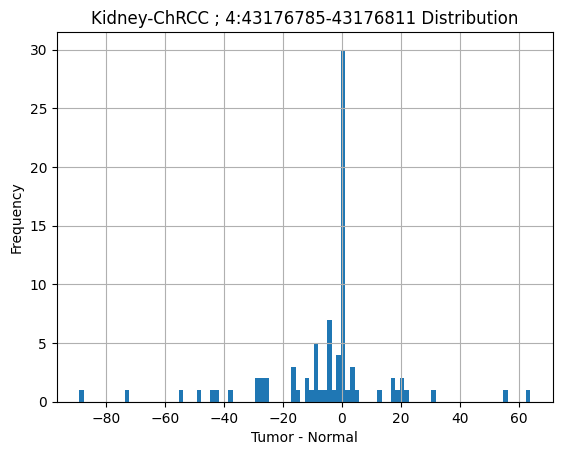

In [80]:
g.graphDiff('4:43176785-43176811', 'Kidney-ChRCC')

In [3]:
kfeats = pd.read_csv('../data/CookerOut/Kidney-ChRCC_feats.csv')
mfeats = pd.read_csv('../data/CookerOut/Myeloid-AML_feats.csv')

In [28]:
kfeats.sort_values('prop_nonzero', ascending=False).head(20)

ReferenceRegion  wilcox_pvals  num_clusters  \
119281     X:41231004-41231040      1.000000             0   
91389     13:58267449-58267479      0.808192             0   
114914    22:32260487-32260511      1.000000             0   
121662     X:98801635-98801663      1.000000             0   
91335     13:57484791-57484831      0.808192             0   
3115     1:175920573-175920597      1.000000             0   
120581     X:76086924-76086966      1.000000             0   
22646      2:57794997-57795027      1.000000             0   
117573   X:144890280-144890361      1.000000             0   
55063          6:834342-834434      0.816818             1   
93941   14:102165258-102165308      0.808192             0   
31632      3:70294822-70294866      0.808192             0   
93914   14:101091234-101091354      1.000000             0   
46902    6:128547906-128547944      0.808192             0   
3256     1:178050912-178050956      1.000000             0   
88667   13:102376947-102376981      1.000000             0   
46651      5:95574005-95574101      0.808192             0   
93755     13:98909202-98909244      1.000000             0   
72075     10:21978570-21978590      1.000000             0   
61788    8:117496570-117496614      1.000000             0   

                cluster_means           cluster_sds  out3  out5  prop_nonzero  \
119281                     []                    []     0     0      0.799649   
91389                      []                    []     0     0      0.799649   
114914                     []                    []     0     0      0.799649   
121662                     []                    []     0     0      0.799649   
91335                      []                    []     0     0      0.799649   
3115                       []                    []     0     0      0.799649   
120581                     []                    []     0     0      0.799649   
22646                      []                    []     0     0      0.799649   
117573                     []                    []     0     0      0.799649   
55063   [-1.4545454545454546]  [3.2575405213034396]     0     0      0.799649   
93941                      []                    []     0     0      0.799649   
31632                      []                    []     2     2      0.799649   
93914                      []                    []     0     0      0.799649   
46902                      []                    []     0     0      0.799649   
3256                       []                    []     0     0      0.799649   
88667                      []                    []     0     0      0.799649   
46651                      []                    []     0     0      0.799649   
93755                      []                    []     0     0      0.799649   
72075                      []                    []     0     0      0.799649   
61788                      []                    []     0     0      0.799649   

              std LocusStructure COSMIC_TumorType COSMIC_TissueType  \
119281        NaN        (AATA)*               -1                -1   
91389    5.656854          (AT)*               -1                -1   
114914        NaN          (AT)*               -1                -1   
121662        NaN          (AT)*               -1                -1   
91335    7.778175          (AT)*               -1                -1   
3115          NaN          (AT)*               -1                -1   
120581        NaN          (AT)*               -1                -1   
22646         NaN          (AT)*               -1                -1   
117573        NaN         (GGA)*               -1                -1   
55063    5.044854        (TCCT)*               -1                -1   
93941   11.313708          (TA)*               -1                -1   
31632    0.000000          (TA)*               -1                -1   
93914    4.949747        (GTGA)*               -1                -1   
46902    0.00000

In [32]:
mfeats.sort_values('wilcox_pvals')

ReferenceRegion  wilcox_pvals  num_clusters  \
0       1:11208969-11208985      0.435807             0   
39901  10:84396570-84396590      0.435807             1   
39902  10:84403660-84403678      0.435807             0   
39903  10:84436800-84436818      0.435807             0   
39904  10:84459006-84459034      0.435807             0   
...                     ...           ...           ...   
22343   5:37910992-37911020      1.000000             0   
34230   8:83674195-83674229      1.000000             0   
22344   5:37969020-37969044      1.000000             0   
22335     5:3776920-3776954      1.000000             1   
52489  16:13139454-13139496      1.000000             1   

                cluster_means            cluster_sds  out3  out5  \
0                          []                     []     0     0   
39901  [-0.11764705882352941]  [0.32218973970892123]     0     0   
39902                      []                     []     0     0   
39903                      []                     []     0     0   
39904                      []                     []     0     0   
...                       ...                    ...   ...   ...   
22343                      []                     []     0     0   
34230                      []                     []     0     0   
22344                      []                     []     0     0   
22335   [0.06666666666666667]  [0.24944382578492946]     0     0   
52489  [-0.18181818181818182]   [0.5749595745760688]     0     0   

       prop_nonzero       std LocusStructure  \
0          0.169576  0.267261          (TG)*   
39901      0.101746  9.877022          (TG)*   
39902      0.067830  0.242536          (CA)*   
39903      0.101746  0.250000          (TC)*   
39904      0.101746  0.250000        (GGAA)*   
...             ...       ...            ...   
22343      0.169576  0.377964          (TG)*   
34230      0.271322  0.864438          (AC)*   
22344      0.135661  0.365148          (CA)*   
22335      0.135661  0.806226          (GT)*   
52489      0.271322  1.083625      (GAGGGA)*   

                                        COSMIC_TumorType COSMIC_TissueType  \
0      endometrial carcinoma, head and neck, clear ce...                 E   
39901                                                 -1                -1   
39902                                                 -1                -1   
39903                                                 -1                -1   
39904                                                 -1                -1   
...                                                  ...               ...   
22343                                                 -1                -1   
34230                                                 -1                -1   
22344                                                 -1                -1   
22335                                                 -1                -1   
52489                                                 -1                -1   

      COSMIC_GeneSymbol  COSMIC_Tier         COSMIC_loc  
0                  MTOR            1  11166592-11322564  
39901                -1           -1              -1--1  
39902                -1           -1              -1--1  
39903                -1           -1              -1--1  
39904                -1           -1              -1--1  
...                 ...          ...                ...  
22343                -1           -1              -1--1  
34230                -1           -1              -1--1  
22344                -1           -1              -1--1  
22335                -1           -1              -1--1  
52489                -1           -1              -1--1  

[64652 rows x 15 columns]

In [35]:
kdiffs = pd.read_csv('../data/CookerOut/Kidney-ChRCC_diff.csv')

In [36]:
import ExpansionFeatureExtractor as ef

In [47]:
import matplotlib.pyplot as plt

In [51]:
# make test pandas df
test = pd.DataFrame({'loc': [1, 0, 0, 5, np.nan]})

In [55]:
test.isnull().sum(axis=0)

loc    1
dtype: int64

(array([83934., 28617., 16981., 11683.,  7699.,  4036.,  4019.,  3702.,
         4118.,  4597.]),
 array([ 0. ,  8.5, 17. , 25.5, 34. , 42.5, 51. , 59.5, 68. , 76.5, 85. ]),
 <BarContainer object of 10 artists>)

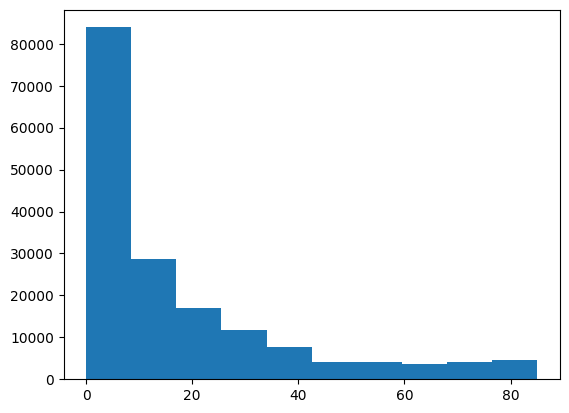

In [49]:
plt.hist(kdiffs.isnull().sum(axis=0).values)

In [61]:
kdiffs.iloc[:, 1:]

10:100022917-100022931  10:100038800-100038825  10:100039453-100039505  \
0                      0.0                     0.0                     0.0   
1                      0.0                     0.0                     NaN   
2                      0.0                     0.0                     0.0   
3                      0.0                     0.0                    -1.0   
4                      0.0                     0.0                     0.0   
..                     ...                     ...                     ...   
81                     0.0                     0.0                     NaN   
82                     0.0                     0.0                     0.0   
83                     NaN                     0.0                     0.0   
84                     0.0                     1.0                     0.0   
85                     NaN                     0.0                     NaN   

    10:100042272-100042300  10:100046867-100046899  10:100120299-100120329  \
0                      0.0                     0.0                     0.0   
1                      0.0                    -2.0                     NaN   
2                      0.0                     0.0                     0.0   
3                     -2.0                     NaN                     0.0   
4                      0.0                     0.0                     0.0   
..                     ...                     ...                     ...   
81                     NaN                     NaN                     NaN   
82                     0.0                     0.0                     0.0   
83                     0.0                     NaN                     NaN   
84                     0.0                     0.0                     0.0   
85                    -4.0                    -5.0                     NaN   

    10:100125057-100125073  10:100131900-100131938  10:100154300-100154336  \
0                      0.0                     0.0                     0.0   
1                      0.0                     NaN                    -1.0   
2                      0.0                     0.0                     0.0   
3                      0.0                    -2.0                    -1.0   
4                      0.0                     0.0                     1.0   
..                     ...                     ...                     ...   
81                     0.0                     NaN                     NaN   
82                     0.0                     0.0                     0.0   
83                     0.0                     0.0                     NaN   
84                     0.0                     0.0                     0.0   
85                     0.0                    -1.0                    -2.0   

    10:100181736-100181772  ...  X:99735823-99735843  X:99751414-99751430  \
0                      0.0  ...                  NaN                  0.0   
1                     -3.0  ...                  NaN                  0.0   
2                      3.0  ...                  0.0                  0.0   
3                      0.0  ...                  NaN                  0.0   
4                      0.0  ...                  NaN                  0.0   
..                     ...  ...                  ...                  ...   
81                     NaN  ...                  NaN                  0.0   
82                     0.0  ...                  0.0                  0.0   
83                     NaN  ...                  NaN                  NaN   
84                     0.0  ...                  NaN                  0.0   
85                    -1.0  ...                  NaN                  NaN   

    X:99760517-99760545  X:99790072-99790098  X:9979677-9979703  \
0                   0.0                  0.0                1.0   
1                   0.0                  0.0                0.0   
2                   0.0                  0.0                0.0   


In [64]:
reload(ef)
feats = ef.process_and_extract_features(kdiffs.iloc[:, 1:])

AttributeError: module 'pyranges' has no attribute 'PyRaanges'

In [17]:
from importlib import reload
reload(g)

<module 'Graphers' from '/Users/wfinot/S23/TR-23/MiniMutes/src/Graphers.py'>

In [8]:
os.environ['DIFF_FOLDER'] = '../data/CookerOut/'
os.environ['GENO_FOLDER'] = '../data/CookerOut/'
print(os.getenv('GENO_FOLDER'))

../data/CookerOut/


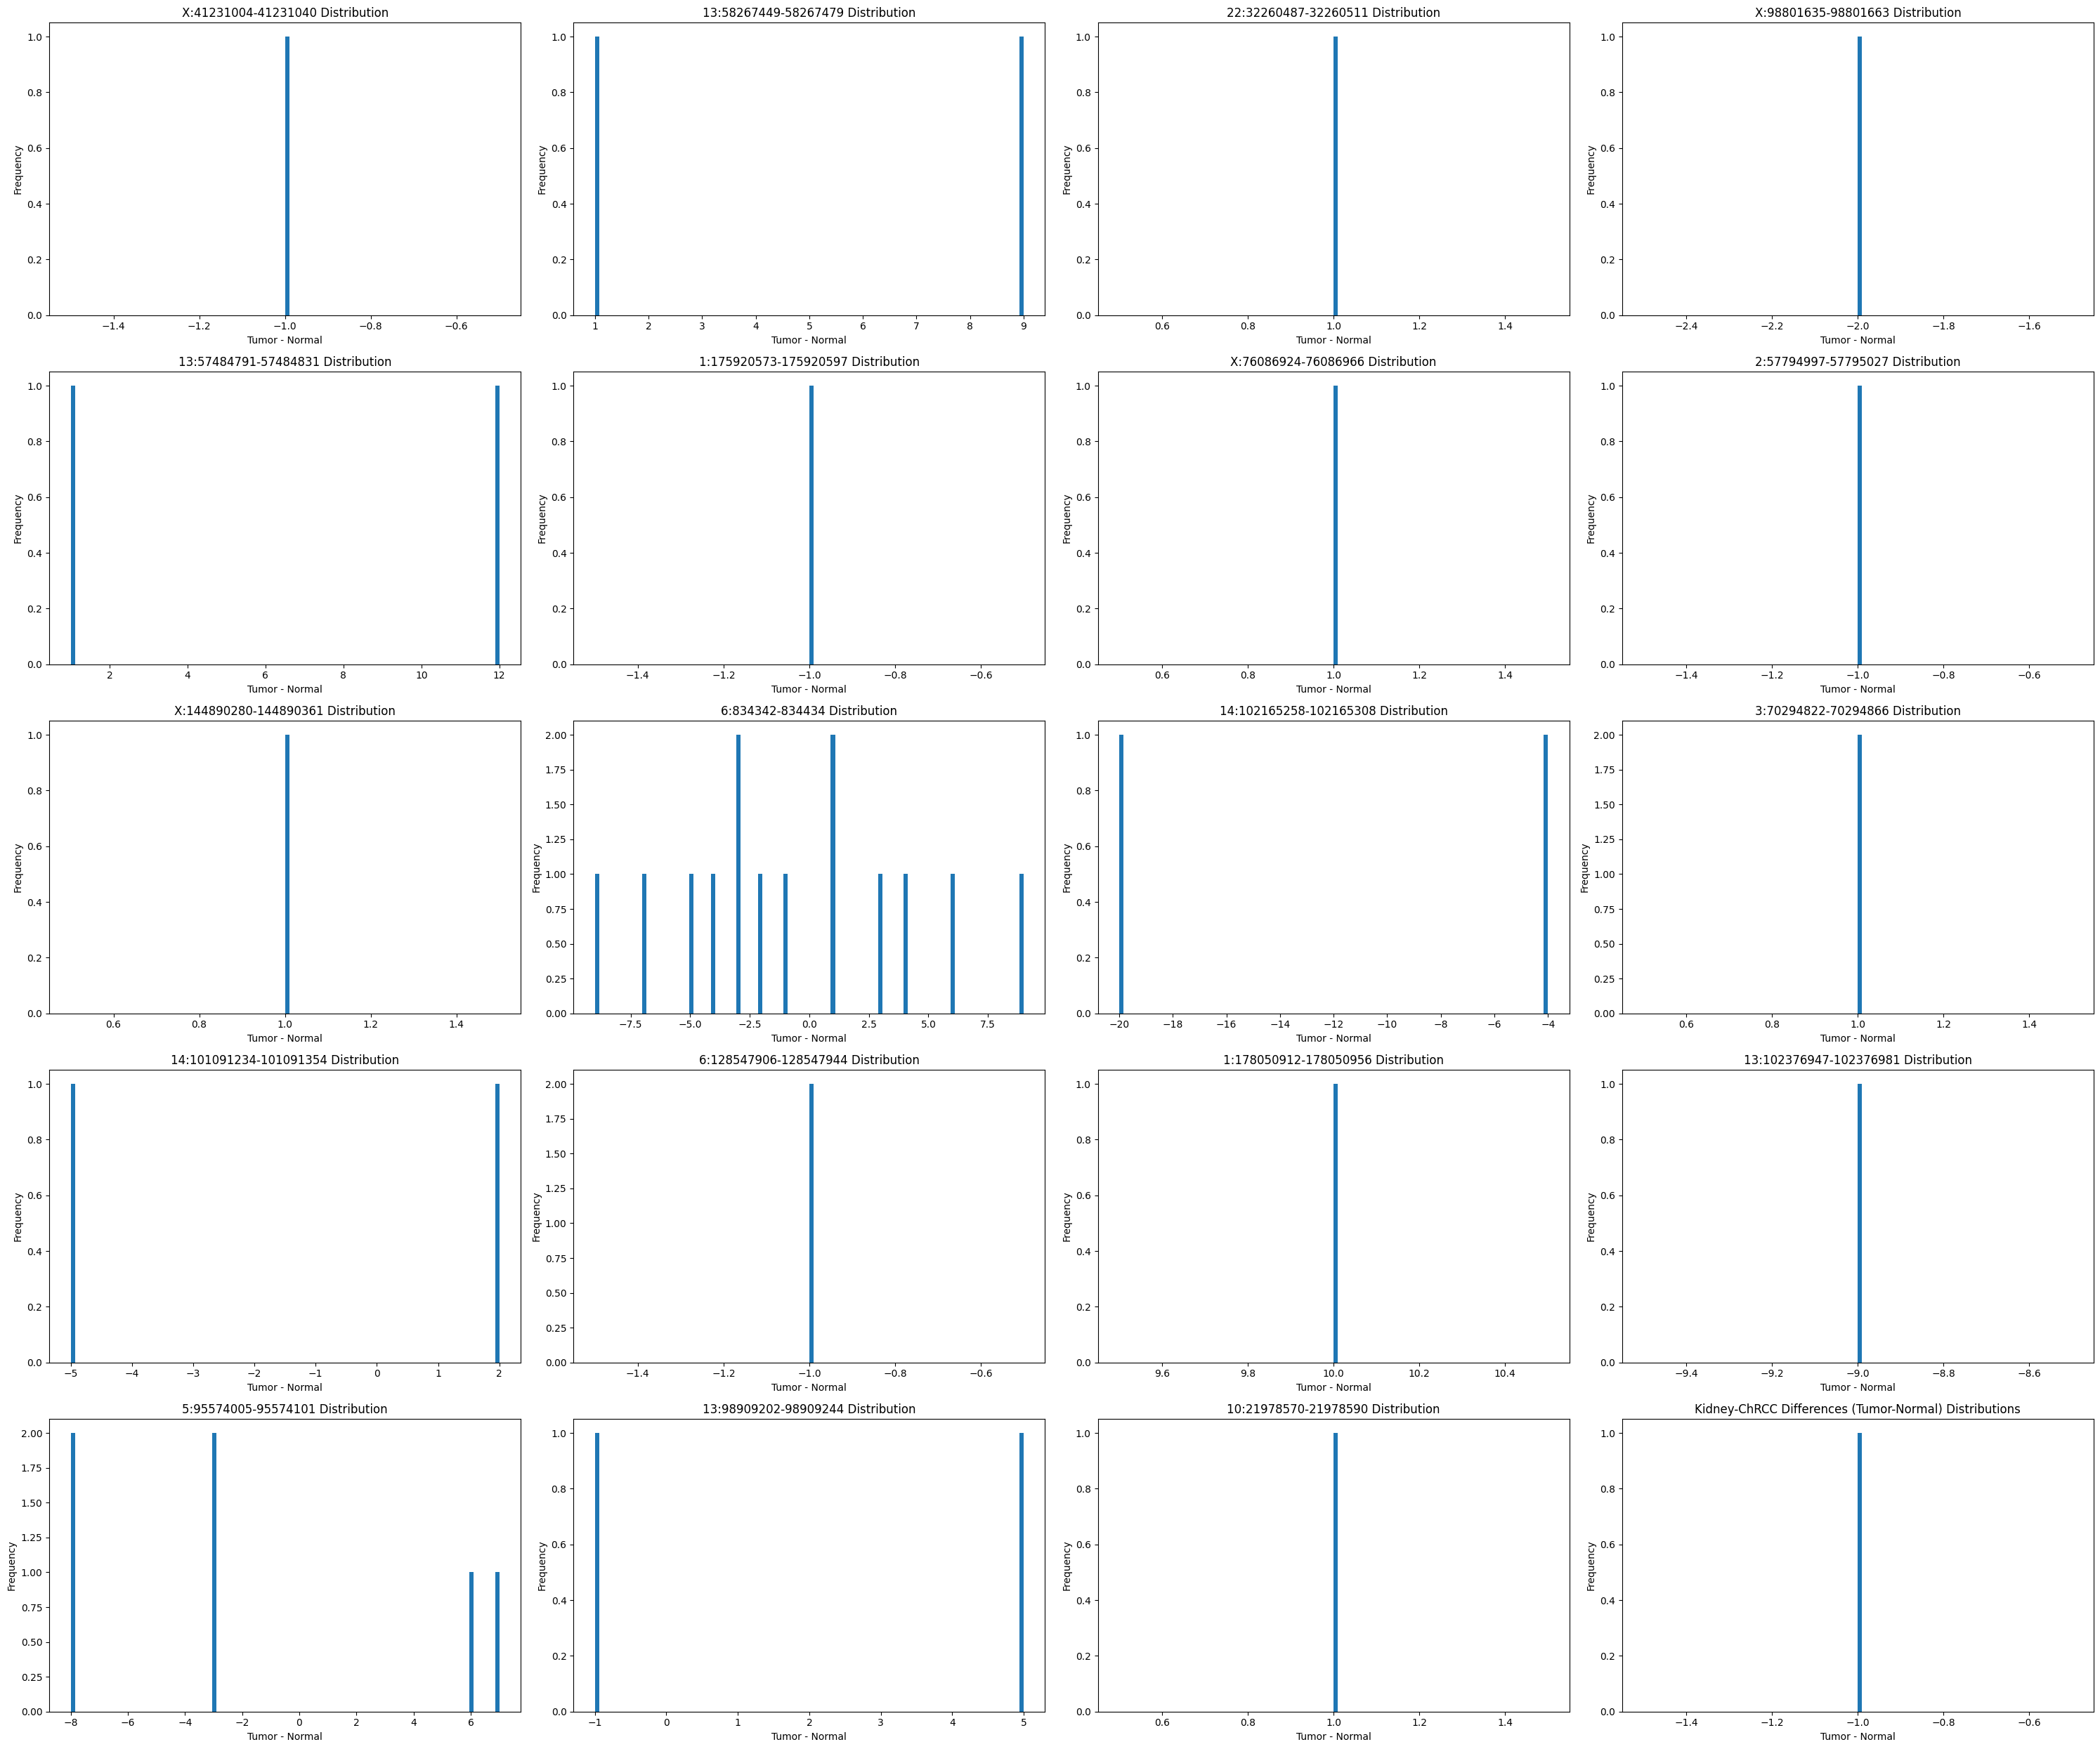

In [30]:
g.graphLociDiffs(kfeats.sort_values('prop_nonzero', ascending=False).head(20)['ReferenceRegion'].values, 'Kidney-ChRCC')

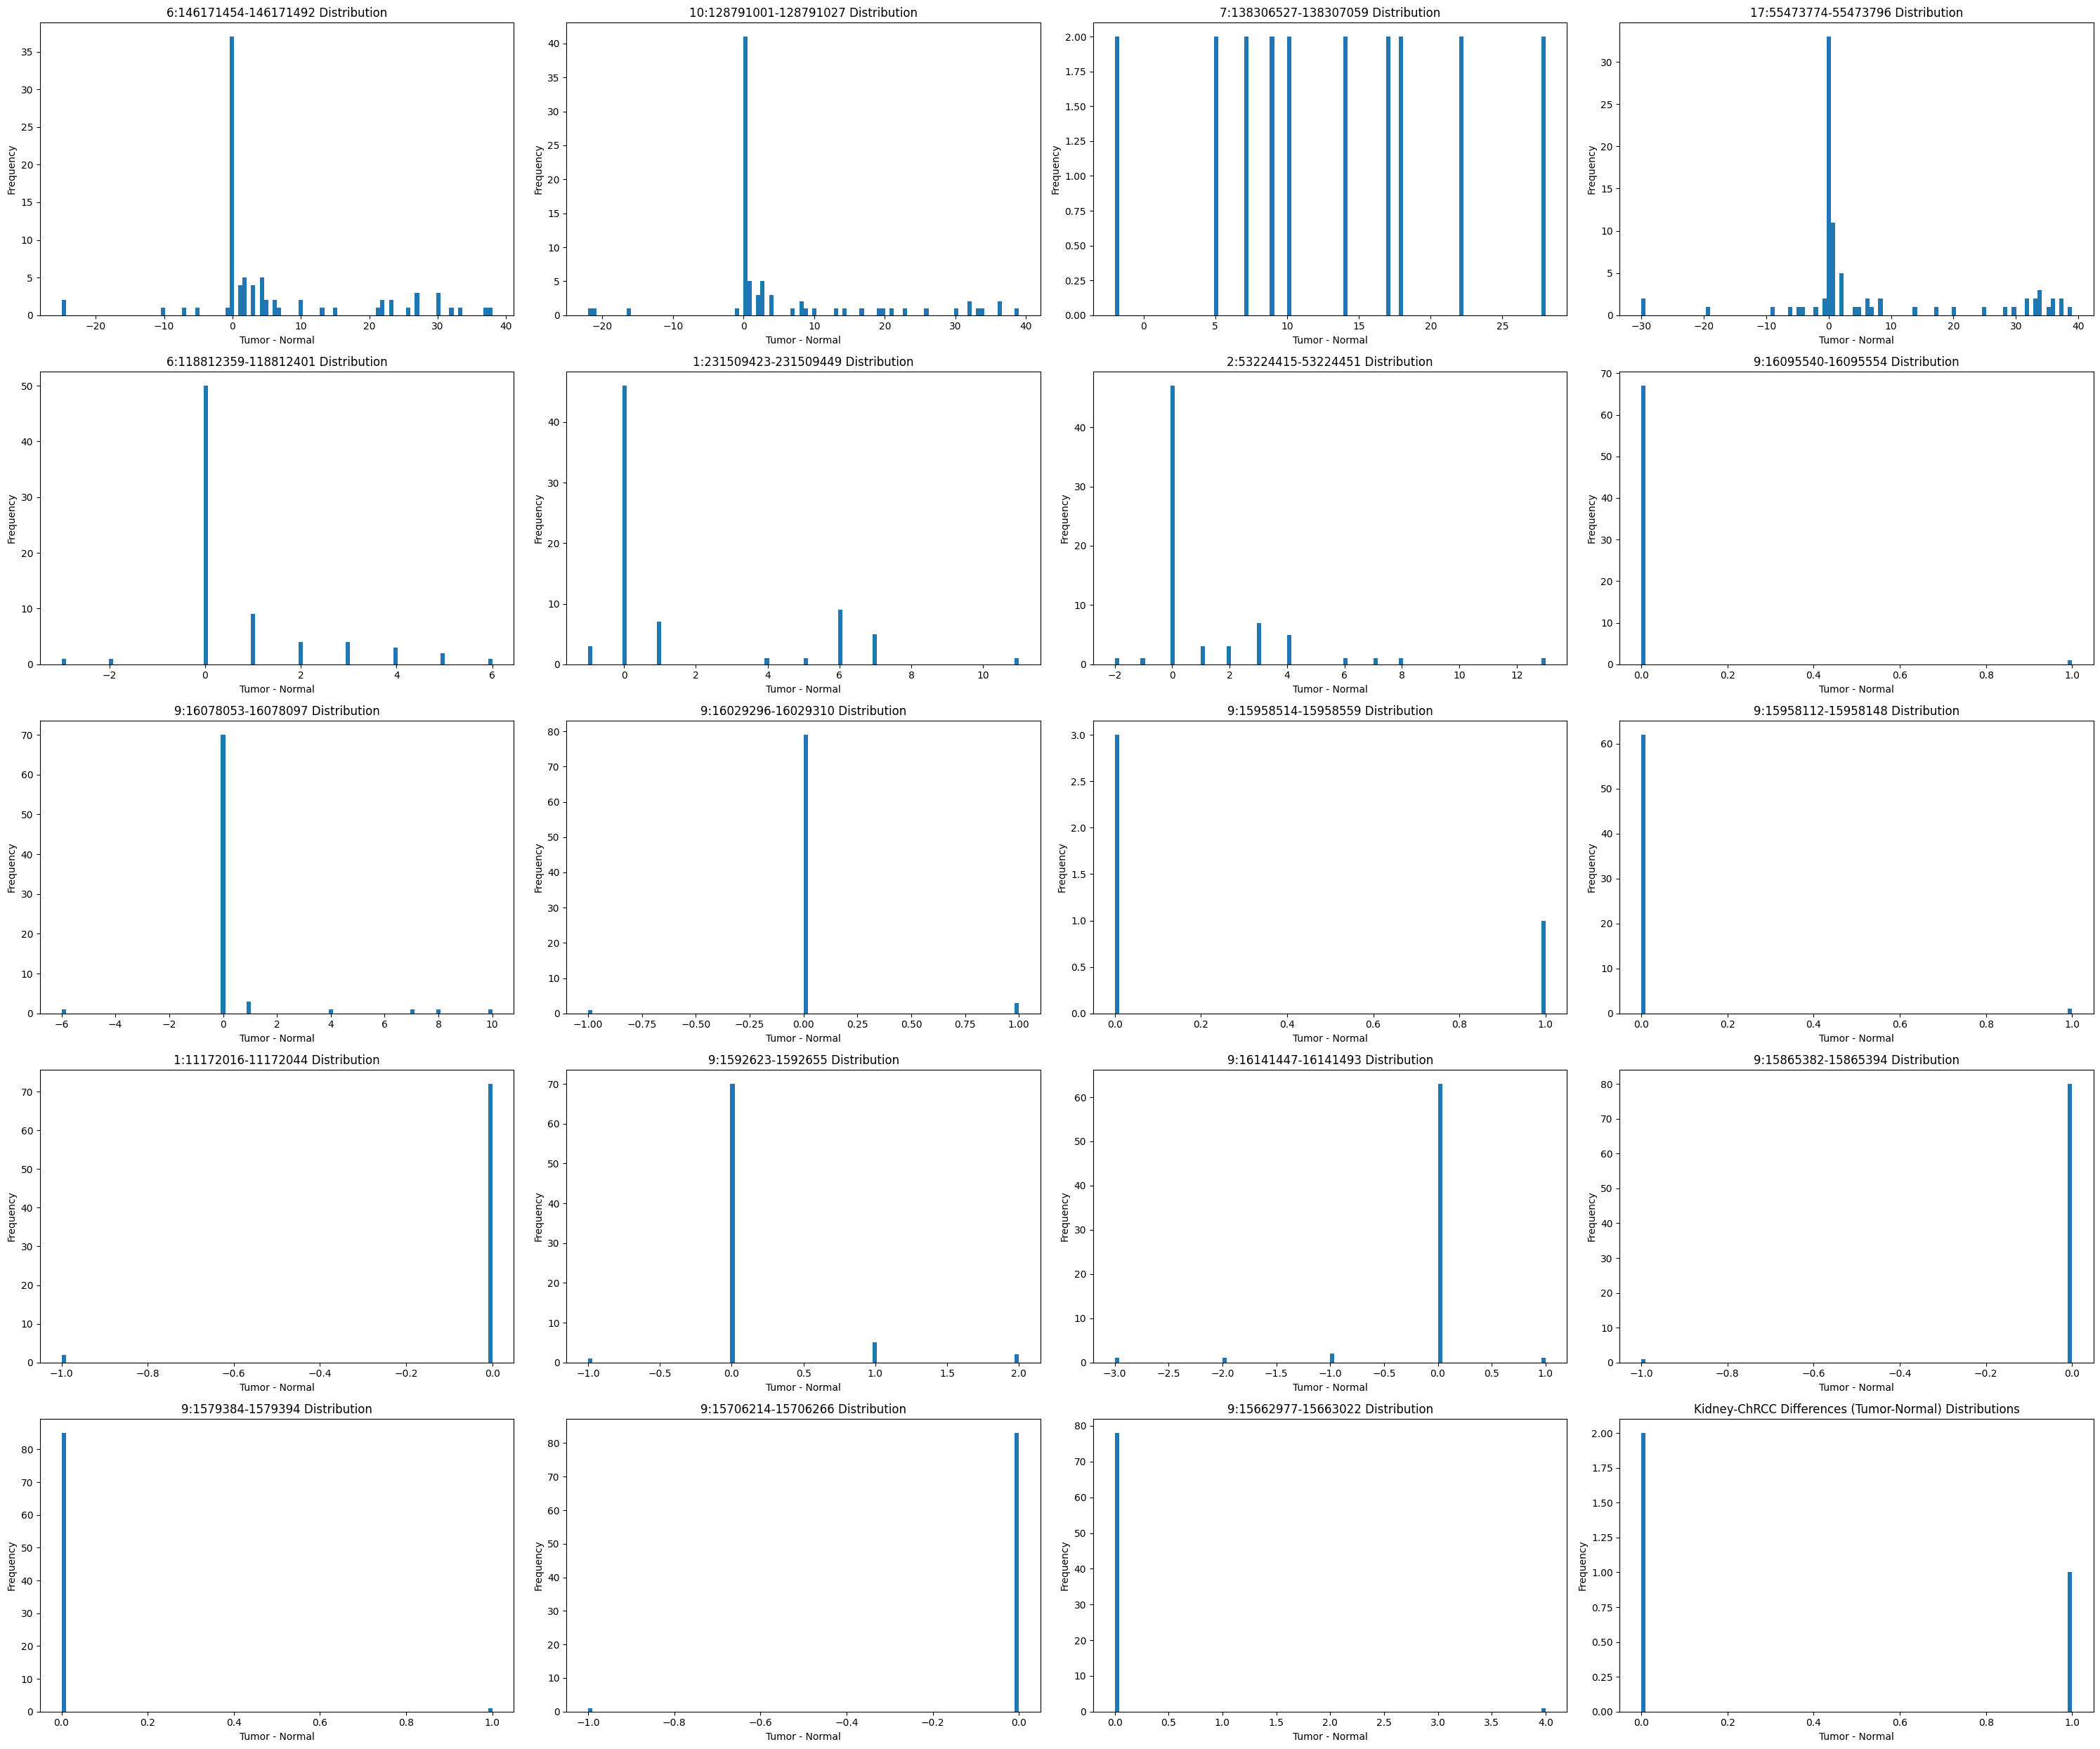

In [22]:
g.graphLociDiffs(kfeats.sort_values('wilcox_pvals').head(20)['ReferenceRegion'].values, 'Kidney-ChRCC')

In [2]:
import objgraph
from memory_profiler import profile

In [3]:
case = orjson.loads(open('/Users/wfinot/S23/TR-23/MiniMutes/Ch/raw_eh/7a33dc42-6a77-4e0d-8ac6-c4b3073c45e7.json').read())
control = orjson.loads(open('/Users/wfinot/S23/TR-23/MiniMutes/Ch/raw_eh/ef926c9e-d08f-4d95-9525-1a3b8446e743.json').read())

In [4]:
import re
from collections import Counter



In [25]:
import argparse
import pandas as pd
import orjson
import os
import numpy as np
import logging
from datetime import datetime
import logging.handlers
from ExpansionFeatureExtractor import process_features
import re
from collections import Counter
import random

from multiprocessing import Pool, cpu_count
from functools import partial

MIN_READS = 6
HIGH_COV = 24
MAX_WIDTH = 4

LOG_LEVEL = os.getenv('LOG_LEVEL') or 'info'
log_dict = {'debug': logging.DEBUG, 'info': logging.INFO, 'warning': logging.WARNING, 
            'error': logging.ERROR, 'critical': logging.CRITICAL}
log_level = log_dict.get(LOG_LEVEL.lower(), logging.INFO)

slurm_job_id = os.getenv('SLURM_JOBID')
if not slurm_job_id:
    slurm_job_id = datetime.now().strftime('%Y%m%d_%H%M')


log_dir = 'ExpansionCookerLogs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

logging.basicConfig(filename=os.path.join(log_dir, f'{slurm_job_id}_ExpansionCooker.log'), 
                    level=log_level,
                    format='%(asctime)s %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')


def is_wide(ci):
    ci = list(map(int, ci.split('-')))
    return ci[1] - ci[0] > MAX_WIDTH

def decide_genotype_order(case, control):

    if case[1] == control[0]:
        temp = case[1]
        case[1] = case[0]
        case[0] = temp


    return case, control

def getPairs(case_ci, control_ci, case_genotypes, control_genotypes):
    if is_wide(case_ci[0]):
        if is_wide(control_ci[1]):
            return [case_genotypes[1], control_genotypes[0]], [case_ci[0], control_ci[1]]
        else:
            return [case_genotypes[1], control_genotypes[1]], [case_ci[0], control_ci[0]]
    else:
        if is_wide(control_ci[0]):
            return [case_genotypes[0], control_genotypes[1]], [case_ci[1], control_ci[0]]
        else:
            return [case_genotypes[0], control_genotypes[0]], [case_ci[1], control_ci[1]]


class GenotypeChecker:
    def __init__(self, genotypes, spanning_reads, flanking_reads):
        self.genotypes = genotypes
        self.spanning_reads_dict = self._parse_reads_to_dict(spanning_reads)
        self.flanking_reads_list = sorted(self.parse_counts(flanking_reads))
        self.supported_genotypes = []
        self.tot_spanning = sum(self.spanning_reads_dict.values())
        self.tot_flanking = len(self.flanking_reads_list)

    def get_lowest_genotype(self):
        return min(self.supported_genotypes)
    
    def _parse_reads_to_dict(self, reads):
        reads = self.parse_counts(reads)
        return Counter(reads)

    def add_genotypes(self, genotypes):
        # append to front of list
        self.genotypes = genotypes + self.genotypes
        
    def num_reads(self):
        return self.tot_spanning + (self.tot_flanking / 4)

    def _count_flanking_below_threshold(self, threshold):
        count = 0
        for read in self.flanking_reads_list:
            if read <= threshold:
                count += 1
            else:
                break  # since the list is sorted, we can break once we pass the threshold
        return count
    
    def parse_counts(self, s):
        """
        Parse the counts of reads.

        :param s: String containing the counts of reads.
        """
        
        # Adjusted the regex to ensure proper matching
        pairs = re.findall(r'\((\d+),\s*(\d+)\)', s)
        
        # Convert strings to integers and expand based on counts
        result = []
        for length, count in pairs:
            result.extend([int(length)] * int(count))
            
        return result

    def _get_spanning_reads_near_genotype(self, genotype):
        """
        Helper method to get spanning reads near the given genotype.
        
        :param genotype: The genotype to check.
        :return: List of spanning reads near the genotype.
        """

        return self.spanning_reads_dict[genotype - 1] + self.spanning_reads_dict[genotype] + self.spanning_reads_dict[genotype + 1]

    def _get_flanking_reads_below_genotype(self, genotype):
        """
        Helper method to get flanking reads below the given genotype.
        Returns proportion of reads under given genotype based on next greatest genotype.
        
        :param genotype: The genotype to check.
        :return: List of flanking reads below the genotype.
        """

        return [read for read in self.flanking_reads_list if read <= genotype]

    def _check_support(self, genotype):
        """
        Private method to check if a genotype is supported by the reads.
        
        :param genotype: The genotype to check.
        :return: Boolean indicating if the genotype is supported.
        """
        SPANNING_UPPER_THRESHOLD = max(4, self.tot_spanning / 3)
        SPANNING_LOWER_THRESHOLD = max(2, self.tot_spanning / 6)
        FLANKING_THRESHOLD = max(6, self.tot_flanking / 4)
        
        close_spanning_reads = self._get_spanning_reads_near_genotype(genotype)
        
        # if genotype shows up > 4 times in spanning reads
        if close_spanning_reads > SPANNING_UPPER_THRESHOLD:
            self._remove_supporting_reads(genotype)
            return True
        
        # elif genotype shows up 2<4 times in spanning reads
        elif SPANNING_LOWER_THRESHOLD < close_spanning_reads <= SPANNING_UPPER_THRESHOLD:
            below_genotype_flanking_reads = self._get_flanking_reads_below_genotype(genotype)
            
            # if more than THRESHOLD reads below genotype
            if len(below_genotype_flanking_reads) > FLANKING_THRESHOLD:
                self._remove_supporting_spanning_reads(genotype)
                self._remove_supporting_flanking_reads(genotype)
                return True
        
        return False
    
    def _remove_supporting_reads(self, genotype):
        """
        Private method to remove reads that support the given genotype.
        """
        self._remove_supporting_spanning_reads(genotype)
        self._remove_supporting_flanking_reads(genotype)
    
    def _remove_supporting_flanking_reads(self, genotype):
        """
        Private method to remove reads that support the given genotype from flanking reads.
        """
        # make new array with reads above genotype
        above = [read for read in self.flanking_reads_list if read > genotype]
        below = [read for read in self.flanking_reads_list if read <= genotype]

        # Calcualte proportion of reads below genotype that belong to gneotype being removed
        b = max(above) if len(above) > 0 else genotype
        r = genotype / b
        prop = 1 - (r / (r+1))

        # remove prop that belonged to genotype
        below = random.sample(below, int(len(below) * prop))
        
        self.flanking_reads_list = above + below
        

    def _remove_supporting_spanning_reads(self, genotype):
        """
        Private method to remove reads that support the given genotype from spanning reads.
        """

        self.spanning_reads_dict[genotype - 1] /= 2
        self.spanning_reads_dict[genotype] /= 2
        self.spanning_reads_dict[genotype + 1] /= 2
        


    def check_genotype(self, genotype):
        """
        Checks if the given genotype is supported by the reads. Removes the supporting reads if so
        
        :param genotype: The genotype to check.
        :return: Boolean indicating if the genotype is supported.
        """
        return self._check_support(genotype)


    def identify_supported_genotypes(self):
        """
        Identify and return the genotypes that are supported by the reads.
        
        :return: List of supported genotypes.
        """
        for genotype in self.genotypes:
            if self._check_support(genotype):
                self.supported_genotypes.append(genotype)
                self._remove_supporting_reads(genotype)
        return self.supported_genotypes or []
    
def append_genotype_data(case_genotypes, control_genotypes, donor_id, ReferenceRegion,
                         local_case_df, local_control_df, local_diff_df):
    if len(case_genotypes) == 2:
        case_genotypes, control_genotypes = decide_genotype_order(case_genotypes, control_genotypes)

    for i in range(len(case_genotypes)):
        local_case_df.append({'donor_id': donor_id + f'_{i}', 'ReferenceRegion': ReferenceRegion, 'value': case_genotypes[i]})
        local_control_df.append({'donor_id': donor_id + f'_{i}', 'ReferenceRegion': ReferenceRegion, 'value': control_genotypes[i]})
        local_diff_df.append({'donor_id': donor_id + f'_{i}', 'ReferenceRegion': ReferenceRegion, 'value': case_genotypes[i] - control_genotypes[i]})


def process_locus(donor_id, data_case, data_control, local_case_df, local_control_df, local_diff_df, local_df_tracking):
    allele_count = data_case['AlleleCount']
    high_cov = HIGH_COV
    min_reads = MIN_READS
    if allele_count == 1:
        high_cov = HIGH_COV / 2
        min_reads = MIN_READS / 2
    for variant in set(data_case['Variants']):
        case = data_case['Variants'][variant]
        control = data_control['Variants'][variant]
        ReferenceRegion = data_case['Variants'][variant]['ReferenceRegion']

        try: 
            control_genotypes = list(map(int, control.get('Genotype').split('/')))
            case_genotypes = list(map(int, case.get('Genotype').split('/')))
        except AttributeError as a:
            continue
        
        # make genotype checker objects for case and cotrol
        case_genotype_checker = GenotypeChecker(case_genotypes, case.get('CountsOfSpanningReads'), case.get('CountsOfFlankingReads'))
        control_genotype_checker = GenotypeChecker(control_genotypes, control.get('CountsOfSpanningReads'), control.get('CountsOfFlankingReads'))

        case_num = case_genotype_checker.num_reads()
        control_num = control_genotype_checker.num_reads()

        # if very high read count, trust Egor's genotypes
        if case_num > high_cov and control_num > high_cov:
            append_genotype_data(case_genotypes, control_genotypes, donor_id, ReferenceRegion, 
                                 local_case_df, local_control_df, local_diff_df)
            continue

        # if very low read count, skip (REVISIT)
        if case_num < min_reads:
            # log to tracking and continue
            local_df_tracking.append({'donor_id': donor_id, 
                            'ReferenceRegion': ReferenceRegion,
                            'motif': case.get('RepeatUnit'),
                            'issue': 'case_low_reads'})
            local_df_tracking.append({'donor_id': donor_id, 
                            'ReferenceRegion': ReferenceRegion,
                            'motif': case.get('RepeatUnit'),
                            'issue': 'case_low_reads'})
            continue

        if control_num < min_reads:
            local_df_tracking.append({'donor_id': donor_id, 
                            'ReferenceRegion': ReferenceRegion,
                            'motif': case.get('RepeatUnit'),
                            'issue': 'control_low_reads'})
            local_df_tracking.append({'donor_id': donor_id, 
                            'ReferenceRegion': ReferenceRegion,
                            'motif': case.get('RepeatUnit'),
                            'issue': 'case_low_reads'})
            continue

        
        # if there is a big difference in read counts, skip (REVISIT)
        diff = abs(case_num - control_num)/min(case_num, control_num)
        if diff > 0.5:
            checked_control_genotypes = control_genotype_checker.identify_supported_genotypes()

            if len(checked_control_genotypes) == 0:
                local_df_tracking.append({'donor_id': donor_id, 
                                'ReferenceRegion': ReferenceRegion,
                                'motif': case.get('RepeatUnit'),
                                'issue': 'control_low_reads'})
                local_df_tracking.append({'donor_id': donor_id, 
                                'ReferenceRegion': ReferenceRegion,
                                'motif': case.get('RepeatUnit'),
                                'issue': 'control_low_reads'})
                continue
            control_is_first = checked_control_genotypes[0] == control_genotypes[0]
            case_genotype_checker.add_genotypes(checked_control_genotypes)
            checked_case_genotypes = case_genotype_checker.identify_supported_genotypes()

            if len(checked_case_genotypes) == 0:
                local_df_tracking.append({'donor_id': donor_id, 
                                'ReferenceRegion': ReferenceRegion,
                                'motif': case.get('RepeatUnit'),
                                'issue': 'case_low_reads'})
                local_df_tracking.append({'donor_id': donor_id, 
                                'ReferenceRegion': ReferenceRegion,
                                'motif': case.get('RepeatUnit'),
                                'issue': 'case_low_reads'})
                continue
            final_case_genotypes = []
            
            i = 0
            while i < len(checked_control_genotypes):
                if checked_control_genotypes[i] in checked_case_genotypes:
                    checked_case_genotypes.remove(checked_control_genotypes[i])
                    final_case_genotypes.append(checked_control_genotypes[i])
                i += 1
            i = 0
            checked_case_genotypes = sorted(checked_case_genotypes)
            while len(final_case_genotypes) < len(checked_control_genotypes) and i < len(checked_case_genotypes):
                if control_is_first:
                    final_case_genotypes.append(checked_case_genotypes[i])

                i += 1
                    
            # make sure we have the same number of genotypes
            if len(checked_control_genotypes) < len(final_case_genotypes):
                final_case_genotypes = final_case_genotypes[:len(checked_control_genotypes)]
            elif len(checked_control_genotypes) > len(final_case_genotypes):
                checked_control_genotypes = checked_control_genotypes[:len(final_case_genotypes)]
            

            append_genotype_data(final_case_genotypes, checked_control_genotypes, donor_id, ReferenceRegion, 
                                 local_case_df, local_control_df, local_diff_df)
            continue

        
        # otherwise, use CI approach
        ci_approach(allele_count, donor_id, case, control, local_case_df, local_control_df, local_diff_df, local_df_tracking)
        

def ci_approach(allele_count, donor_id, case, control, local_case_df, local_control_df, local_diff_df, local_df_tracking):
    ReferenceRegion = case['ReferenceRegion']
    # get values
    case_ci = case.get('GenotypeConfidenceInterval')
    control_ci = control.get('GenotypeConfidenceInterval')


    if allele_count == 1:
        if is_wide(case_ci) or is_wide(control_ci):
            local_df_tracking.append({'donor_id': donor_id, 
                                'ReferenceRegion': ReferenceRegion,
                                'motif': case.get('RepeatUnit'),
                                'control_ci': control_ci, 
                                'case_ci': case_ci})
            return

        local_case_df.append({'donor_id': donor_id + '_0', 'ReferenceRegion': ReferenceRegion, 'value': case.get('Genotype')})
        local_control_df.append({'donor_id': donor_id + '_0', 'ReferenceRegion': ReferenceRegion, 'value': control.get('Genotype')})
        return
    if allele_count == 2:

        case_ci = case_ci.split('/')
        control_ci = control_ci.split('/')
        case_genotypes = case.get('Genotype')
        control_genotypes = control.get('Genotype')
        case_genotypes = list(map(int, case_genotypes.split('/')))
        control_genotypes = list(map(int, control_genotypes.split('/')))
        # make any genotypes with a wide confidence interval nan
        if is_wide(case_ci[0]):
            case_genotypes[0] = np.nan
        if is_wide(case_ci[1]):
            case_genotypes[1] = np.nan
        if is_wide(control_ci[0]):
            control_genotypes[0] = np.nan
        if is_wide(control_ci[1]):
            control_genotypes[1] = np.nan

        tot_wide = np.isnan(case_genotypes).sum() + np.isnan(control_genotypes).sum()

        if tot_wide == 0:
            append_genotype_data(case_genotypes, control_genotypes, donor_id, ReferenceRegion,
                                 local_case_df, local_control_df, local_diff_df)
            return

        # if 3 out of 4 values are nan, skip
        if tot_wide >= 3 or (is_wide(case_ci[0]) and is_wide(case_ci[1])) or (is_wide(control_ci[0]) and is_wide(control_ci[1])):
            local_df_tracking.append({'donor_id': donor_id, 
                                'ReferenceRegion': ReferenceRegion, 
                                'motif': case.get('RepeatUnit'),
                                'control_ci': control_ci[0], 
                                'case_ci': case_ci[0]})
            local_df_tracking.append({'donor_id': donor_id, 
                                'ReferenceRegion': ReferenceRegion, 
                                'motif': case.get('RepeatUnit'),
                                'control_ci': control_ci[1], 
                                'case_ci': case_ci[1]})
            return
        
        goodPair, badCi = getPairs(case_ci, control_ci, case_genotypes, control_genotypes)
        local_case_df.append({'donor_id': donor_id + '_0', 'ReferenceRegion': ReferenceRegion, 'value': goodPair[0]})
        local_control_df.append({'donor_id': donor_id + '_0', 'ReferenceRegion': ReferenceRegion, 'value': goodPair[1]})
        local_diff_df.append({'donor_id': donor_id + '_0', 'ReferenceRegion': ReferenceRegion, 'value': goodPair[0] - goodPair[1]})
        local_df_tracking.append({'donor_id': donor_id, 
                            'ReferenceRegion': ReferenceRegion,
                            'motif': case.get('RepeatUnit'),
                            'control_ci': badCi[1], 
                            'case_ci': badCi[0]})

In [26]:
process_locus("test", case['LocusResults']['chr2_124448269_124448299'], control['LocusResults']['chr2_124448269_124448299'], case_df, control_df, diff_df, df_tracking)

In [19]:
len(case_df)

6310

In [6]:
case_df = []
control_df = []
diff_df = []
df_tracking = []


In [8]:
import itertools

In [28]:
%%prun -s cumulative -q -l 10 -T prun0

for i, locus in enumerate(itertools.islice(set(case['LocusResults']), 100000)):
    print(locus)
    process_locus("test", case['LocusResults'][locus], control['LocusResults'][locus], case_df, control_df, diff_df, df_tracking)
    print(i)


chrX_136865143_136865158
0
chr2_178824061_178824089
1
chr4_4021967_4022003
2
chr11_129507288_129507306
3
chr8_34222037_34222049
4
chr5_111408116_111408138
5
chr13_47914099_47914115
6
chr20_62202438_62202458
7
chrX_82683918_82683954
8
chr4_17090496_17090532
9
chr14_21388483_21388503
10
chr16_6634072_6634102
11
chrX_127274474_127274502
12
chr10_29747364_29747406
13
chr9_79807798_79807830
14
chr22_23813823_23813838
15
chr1_24191667_24191691
16
chr9_37612344_37612362
17
chrX_107824380_107824416
18
chr17_1088452_1088494
19
chr7_11178433_11178451
20
chr9_70044386_70044404
21
chr10_81419064_81419100
22
chr3_2594774_2594782
23
chr1_91909677_91909705
24
chr5_86106297_86106313
25
chr7_34391202_34391270
26
chr5_176633213_176633241
27
chr7_43250118_43250134
28
chr3_53870648_53870660
29
chr1_245401869_245401889
30
chr8_32600325_32600353
31
chr20_23277948_23277964
32
chr12_105267317_105267341
33
chr21_44060915_44060947
34
chr16_57455397_57455417
35
chr1_112908997_112909027
36
chr15_57221383_57221411

In [17]:
objgraph.show_most_common_types()


dict                       716490
function                   36206
Token                      23361
tuple                      19740
list                       19672
cell                       8330
ReferenceType              7544
getset_descriptor          4866
builtin_function_or_method 4855
type                       3810


In [7]:
%load_ext memory_profiler

In [19]:
@profile
def run_code():
    for i, locus in enumerate(itertools.islice(set(case['LocusResults']),1000)):
        process_locus("test", case['LocusResults'][locus], control['LocusResults'][locus], case_df, control_df, diff_df, df_tracking)

%mprun -f process_locus run_code()

ERROR: Could not find file /var/folders/fy/1nmbptg97yqfwbr_y2kq5zbr0000gn/T/ipykernel_62465/3326319342.py



Filename: /Users/wfinot/S23/TR-23/MiniMutes/src/ExpansionCooker.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   239   1359.6 MiB   1358.1 MiB        1000   def process_locus(donor_id, data_case, data_control, local_case_df, local_control_df, local_diff_df, local_df_tracking):
   240   1359.6 MiB      0.0 MiB        1000       allele_count = data_case['AlleleCount']
   241   1359.6 MiB      0.0 MiB        1000       high_cov = HIGH_COV
   242   1359.6 MiB      0.0 MiB        1000       min_reads = MIN_READS
   243   1359.6 MiB      0.0 MiB        1000       if allele_count == 1:
   244   1359.5 MiB      0.0 MiB          43           high_cov = HIGH_COV / 2
   245   1359.5 MiB      0.0 MiB          43           min_reads = MIN_READS / 2
   246   1359.6 MiB      0.0 MiB        2000       for variant in set(data_case['Variants']):
   247   1359.6 MiB      0.0 MiB        1000           case = data_case['Variants'][variant]
   248   1359.6 MiB      0.0 MiB        1000   

In [17]:
from ExpansionCooker import process_locus


In [20]:
objgraph.show_most_common_types()


dict                       723383
function                   37877
Token                      34265
list                       26425
tuple                      22433
ReferenceType              9350
cell                       8572
builtin_function_or_method 6344
Name                       5550
getset_descriptor          5028


In [21]:
import gc
dictionaries = [obj for obj in gc.get_objects() if isinstance(obj, dict)]


In [22]:

objgraph.show_refs([dictionaries[0]], filename='refs.png')


Graph written to /var/folders/fy/1nmbptg97yqfwbr_y2kq5zbr0000gn/T/objgraph-5kvspygq.dot (26 nodes)
Image renderer (dot) not found, not doing anything else
